In [1]:
!pip install einops transformers==4.35.2 more_itertools

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
import torch
from torch import Tensor, tensor, arange, randn, randint, tril, where, ones, allclose, empty, zeros, inference_mode, no_grad, Storage, FloatTensor
from torch.nn import Module, Linear, GELU, ReLU, Parameter, Embedding, ModuleList, LayerNorm, MSELoss, KLDivLoss
from torch.nn.functional import softmax, cross_entropy
from torch.nn.init import zeros_
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset
from datasets import load_dataset, load_from_disk
# from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import pickle
from dataclasses import dataclass
from copy import copy
from typing import Optional, Tuple, Union, Dict, Callable, Iterable, Any
from einops import einsum
from tqdm import tqdm
import matplotlib.pyplot as plt
from os.path import isfile
from os import remove
from math import sqrt, pi, prod
from more_itertools import pairwise
import gc

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using", device)

using cuda


In [4]:
@dataclass
class TransformerConfig:
    vocab_size: int
    ncontext: int
    dmodel: int
    dhead: int
    nhead: int
    dmlp : int
    nlayers: int
    activation_function: Union[Callable, str] = GELU()
    mask_value: float = 1e-5
    attention_scale: float = None

    def __post_init__(self):
        if self.attention_scale is None:
            self.attention_scale = 1 / sqrt(self.dhead)

# copy pasted from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
class NewGELUActivation(Module):
    def forward(self, input: Tensor) -> Tensor:
        return 0.5 * input * (1.0 + torch.tanh(sqrt(2.0 / pi) * (input + 0.044715 * torch.pow(input, 3.0))))

class MLP(Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.up = Linear(cfg.dmodel, cfg.dmlp)
        self.down = Linear(cfg.dmlp, cfg.dmodel)

    def forward(self, x):
        x = self.up(x)
        x = self.cfg.activation_function(x)
        x = self.down(x)
        return x

class Attention(Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        self.query_weight  = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.key_weight    = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.value_weight  = Parameter(randn(cfg.nhead, cfg.dmodel, cfg.dhead) / sqrt(cfg.dmodel))
        self.output_weight = Parameter(randn(cfg.nhead, cfg.dhead, cfg.dmodel) / sqrt(cfg.nhead * cfg.dhead))

        self.query_bias    = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.key_bias      = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.value_bias    = Parameter(randn(cfg.nhead, cfg.dhead) / sqrt(cfg.dmodel))
        self.output_bias   = Parameter(randn(cfg.dmodel)           / sqrt(cfg.nhead * cfg.dhead))

    def forward(self, x):
        ncontext = x.size(-2)

        query = einsum(x, self.query_weight, "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        key   = einsum(x, self.key_weight,   "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        value = einsum(x, self.value_weight, "... ncontext dmodel, nhead dmodel dhead -> ... ncontext nhead dhead")
        query = query + self.query_bias
        key   = key   + self.key_bias
        value = value + self.value_bias

        attention = einsum(
            key,
            query,
            "... ncontext_key nhead dhead, ... ncontext_query nhead dhead -> ... nhead ncontext_query ncontext_key"
        )
        attention = self.cfg.attention_scale * attention
        attention_mask = tril(ones((ncontext, ncontext), dtype=torch.bool, device=device))
        attention = where(attention_mask, attention, tensor(self.cfg.mask_value, device=device))
        attention = softmax(attention, dim=-1)
        
        result = einsum(
            attention,
            value,
            "... nhead ncontext_query ncontext_key, ... ncontext_key nhead dhead -> ... ncontext_query nhead dhead"
        )
        output = einsum(result, self.output_weight, "... ncontext nhead dhead, nhead dhead dmodel -> ... ncontext dmodel")
        output = output + self.output_bias
        return output

@dataclass
class BlockOutput:
    output:                  Tensor
    activations:             Optional[Dict[str, Tensor]] = None
    autoencoder_activations: Optional[Dict[str, Tensor]] = None

class TransformerBlock(Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.attention_layer_norm = LayerNorm(cfg.dmodel)
        self.mlp_layer_norm = LayerNorm(cfg.dmodel)

        self.attention = Attention(cfg)
        self.mlp = MLP(cfg)

    def forward(self, pre, return_activations=False, return_autoencoder_activations=False, autoencoders=dict()):
        assert set(autoencoders.keys()) <= {"pre", "mid", "post", "attentio", "mlp"}

        autoencoder_outputs = dict()

        if "pre" in autoencoders:
            pre, autoencoder_outputs["pre"] = autoencoders["pre"](pre)

        attention = self.attention(self.attention_layer_norm(pre))
        
        if "attention" in autoencoders:
            attention, autoencoder_outputs["attention"] = autoencoders["attention"](attention)
        
        mid = pre + attention
        
        if "mid" in autoencoders:
            mid, autoencoder_outputs["mid"] = autoencoders["mid"](mid)
        
        mlp = self.mlp(self.mlp_layer_norm(mid))
        
        if "mlp" in autoencoders:
            mlp, autoencoder_outputs["mlp"] = autoencoders["mlp"](mlp)
        
        post = mid + mlp
        
        if "post" in autoencoders:
            post, autoencoder_outputs["post"] = autoencoders["post"](post)

        activations = {"mid": mid, "post": post, "attention": attention, "mlp": mlp}

        return BlockOutput(
            output=                  post,
            activations=             activations if return_activations else None,
            autoencoder_activations= autoencoder_outputs if return_autoencoder_activations else None
        )
    
@dataclass
class TransformerOutput:
    logits:                  Tensor
    activations:             Optional[Dict[Tuple[int, str], Tensor]] = None
    autoencoder_activations: Optional[Dict[Tuple[int, str], Tensor]] = None

class Transformer(Module):
    def __init__(self, cfg, tokenizer=None):
        super().__init__()
        if isinstance(cfg.activation_function, str):
            cfg.activation_function = {"gelu": GELU(), "relu": ReLU(), "gelu_new": NewGELUActivation()}[cfg.activation_function]
        
        self.cfg = cfg
        self.tokenizer = tokenizer

        self.embedding = Embedding(cfg.vocab_size, cfg.dmodel)
        self.positional_embedding = Embedding(cfg.ncontext, cfg.dmodel)
        self.blocks = ModuleList([TransformerBlock(cfg) for _ in range(cfg.nlayers)])
        self.unembedding = Linear(cfg.dmodel, cfg.vocab_size)
        self.final_layer_norm = LayerNorm(cfg.dmodel)

    def forward( self,
                 x,
                 return_activations=False,
                 return_autoencoder_activations=False,
                 stop_at_layer=None,
                 autoencoders: Dict[Tuple[int, str], Callable] = dict() ):

        assert all( layer in range(self.cfg.nlayers) and checkpoint in ["pre", "mid", "post", "mlp", "attention"]
                    for layer, checkpoint in autoencoders.keys() )

        if isinstance(x, str):
            x = self.tokenizer(x)

        x = self.embedding(x)
        ncontext = x.size(-2)
        x = x + self.positional_embedding(arange(ncontext, device=device))
        
        activations = dict() if return_activations else None
        autoencoder_activations = dict() if return_autoencoder_activations else None
        
        blocks = self.blocks if stop_at_layer is None else self.blocks[:stop_at_layer]
        for layer, block in enumerate(blocks):
            pre = x

            if layer == 0 and (0, "pre") in autoencoders:
                pre, autoencoder_activations[(0, "pre")] = autoencoders[(0, "pre")](pre)

            auoencoders_on_layer = { checkpoint: autoencoder
                                     for (layer_, checkpoint), autoencoder in autoencoders.items()
                                     if layer_ == layer }
            output = block( x,
                            return_activations=             return_activations,
                            return_autoencoder_activations= autoencoder_activations,
                            autoencoders=                   auoencoders_on_layer )
            x = output.output

            if return_activations:
                for checkpoint, activation in output.activations.items():
                    activations[(layer, checkpoint)] = activation
                if layer == 0:
                    activations[(0, "pre")] = pre

            if return_autoencoder_activations:
                for checkpoint, activation in output.autoencoder_activations.items():
                    activations[(layer, checkpoint)] = activation

        x = self.final_layer_norm(x)
        x = self.unembedding(x)
        
        return TransformerOutput(logits=x, activations=activations, autoencoder_activations=autoencoder_activations)

    @staticmethod
    @inference_mode()
    def from_pretrained(pretrained_model_name, test=True, test_atol=1e-4):
        theirs = AutoModelForCausalLM.from_pretrained(pretrained_model_name).to(device)
        tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

        ours = Transformer(TransformerConfig( vocab_size=          tokenizer.vocab_size,
                                              ncontext=            theirs.config.max_position_embeddings,
                                              dmodel=              theirs.config.hidden_size,
                                              dhead=               theirs.config.hidden_size // theirs.config.num_heads,
                                              nhead=               theirs.config.num_heads,
                                              dmlp=                4 * theirs.config.hidden_size,
                                              nlayers=             theirs.config.num_layers,
                                              activation_function= theirs.config.activation_function,
                                              attention_scale=     1.0,
                                              mask_value=          torch.finfo(torch.float).min )).to(device)
        
        ours.tokenizer = tokenizer

        ours.embedding.weight.copy_(theirs.transformer.wte.weight)
        ours.positional_embedding.weight.copy_(theirs.transformer.wpe.weight)
        ours.unembedding.weight.copy_(theirs.transformer.wte.weight)
        zeros_(ours.unembedding.bias)
        ours.final_layer_norm.weight.copy_(theirs.transformer.ln_f.weight)
        ours.final_layer_norm.bias.copy_(theirs.transformer.ln_f.bias)
                    
        for layer in range(ours.cfg.nlayers):
            ours.blocks[layer].attention_layer_norm.weight.copy_(theirs.transformer.h[layer].ln_1.weight)
            ours.blocks[layer].attention_layer_norm.bias.copy_(theirs.transformer.h[layer].ln_1.bias)
            ours.blocks[layer].mlp_layer_norm.weight.copy_(theirs.transformer.h[layer].ln_2.weight)
            ours.blocks[layer].mlp_layer_norm.bias.copy_(theirs.transformer.h[layer].ln_2.bias)

            ours.blocks[layer].attention.query_weight.copy_(theirs.transformer.h[layer].attn.attention.q_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
            ours.blocks[layer].attention.key_weight.copy_(theirs.transformer.h[layer].attn.attention.k_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
            ours.blocks[layer].attention.value_weight.copy_(theirs.transformer.h[layer].attn.attention.v_proj.weight.reshape(ours.cfg.nhead, ours.cfg.dhead, ours.cfg.dmodel).permute(0, 2, 1))
            ours.blocks[layer].attention.output_weight.copy_(theirs.transformer.h[layer].attn.attention.out_proj.weight.reshape(ours.cfg.dmodel, ours.cfg.nhead, ours.cfg.dhead).permute(1, 2, 0))

            zeros_(ours.blocks[layer].attention.query_bias)
            zeros_(ours.blocks[layer].attention.key_bias)
            zeros_(ours.blocks[layer].attention.value_bias)
            ours.blocks[layer].attention.output_bias.copy_(theirs.transformer.h[layer].attn.attention.out_proj.bias)

            ours.blocks[layer].mlp.up.weight.copy_(theirs.transformer.h[layer].mlp.c_fc.weight)
            ours.blocks[layer].mlp.down.weight.copy_(theirs.transformer.h[layer].mlp.c_proj.weight)

            ours.blocks[layer].mlp.up.bias.copy_(theirs.transformer.h[layer].mlp.c_fc.bias)
            ours.blocks[layer].mlp.down.bias.copy_(theirs.transformer.h[layer].mlp.c_proj.bias)

        if test:
            print("Testing that the model behaves the same as the library model... ", end="", flush=True)
            inputs = randint(0, ours.cfg.vocab_size, (64, 64), device=device)
            assert allclose(ours(inputs).logits, theirs(inputs).logits, atol=test_atol), "Tests failed!"
            print("Test passed!")

        return ours
    
        """
        theirs = HookedTransformer.from_pretrained(pretrained_model_name)
        
        ours = Transformer(TransformerConfig( vocab_size=theirs.tokenizer.vocab_size,
                                      ncontext=theirs.cfg.n_ctx,
                                      dmodel=theirs.cfg.d_model,
                                      dhead=theirs.cfg.d_head,
                                      nhead=theirs.cfg.n_heads,
                                      dmlp=theirs.cfg.d_mlp,
                                      nlayers=theirs.cfg.n_layers,
                                      activation_function=theirs.cfg.act_fn ))

        ours.tokenizer = theirs.tokenizer

        with torch.no_grad():
            ours.embedding.weight.copy_(theirs.embed.W_E)
            ours.positional_embedding.weight.copy_(theirs.pos_embed.W_pos)
            ours.unembedding.weight.copy_(theirs.unembed.W_U.transpose(0, 1))
            ours.unembedding.bias.copy_(theirs.unembed.b_U)
            
            for layer in range(ours.cfg.nlayers):
                ours.blocks[layer].attention.query_weight.copy_(theirs.blocks[layer].attn.W_Q)
                ours.blocks[layer].attention.key_weight.copy_(theirs.blocks[layer].attn.W_K)
                ours.blocks[layer].attention.value_weight.copy_(theirs.blocks[layer].attn.W_V)
                ours.blocks[layer].attention.output_weight.copy_(theirs.blocks[layer].attn.W_O)

                ours.blocks[layer].attention.query_bias.copy_(theirs.blocks[layer].attn.b_Q)
                ours.blocks[layer].attention.key_bias.copy_(theirs.blocks[layer].attn.b_K)
                ours.blocks[layer].attention.value_bias.copy_(theirs.blocks[layer].attn.b_V)
                ours.blocks[layer].attention.output_bias.copy_(theirs.blocks[layer].attn.b_O)

                ours.blocks[layer].mlp.up.weight.copy_(theirs.blocks[layer].mlp.W_in.transpose(0, 1))
                ours.blocks[layer].mlp.down.weight.copy_(theirs.blocks[layer].mlp.W_out.transpose(0, 1))

                ours.blocks[layer].mlp.up.bias.copy_(theirs.blocks[layer].mlp.b_in)
                ours.blocks[layer].mlp.down.bias.copy_(theirs.blocks[layer].mlp.b_out)

        return ours
        """

In [5]:
model = Transformer.from_pretrained("roneneldan/TinyStories-1M", test=True).to(device)
theirs = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1M")
theirs.eval()
_ = model.eval()

Testing that the model behaves the same as the library model... Test passed!


In [6]:
# def train_val_test_split(dataset, val_size=0.1, test_size=0.1):
#     dataset = dataset.train_test_split(test_size=val_size+test_size)
#     val_test_dataset = dataset["test"].train_test_split(test_size = val_size / (val_size + test_size))
#     return DatasetDict({ "train": dataset["train"],
#                          "val":   val_test_dataset["train"],
#                          "test":  val_test_dataset["test"] })

def make_tokens_dataset(text_dataset, tokenizer):
    tokens_dataset = text_dataset.map(lambda datapoint: tokenizer(datapoint["text"]))
    tokens_dataset = tokens_dataset.remove_columns(["text", "attention_mask"])
    tokens_dataset.set_format("torch")
    return tokens_dataset

def all_equal(xs):
    return all(current == next for current, next in pairwise(xs))

class DictTensorDataset(Dataset):
    def __init__(self, tensors: Dict[Any, Tensor]):
        assert all_equal(tensor.size(0) for tensor in tensors.values()), "Size mismatch between tensors"
        self.tensors = tensors

    def __len__(self):
        return next(iter(self.tensors.values())).size(0)

    def __getitem__(self, index):
        return {key: tensor[index] for key, tensor in self.tensors.items()}

def dict_collate_fn(dicts: Iterable[Dict[Any, Tensor]]):
    if not isinstance(dicts, list):
        dicts = list(dicts)

    collated = { key: empty(len(dicts), *tensor.shape)
                 for key, tensor in dicts[0].items() }

    for i, dict in enumerate(dicts):
        for key, tensor in dict.items():
            collated[key][i, :] = tensor

    return collated

def english_join(xs, comma=", ", and_=" and ", oxford_and=", and "):
    xs = list(xs)
    if len(xs) == 0:
        return ""
    if len(xs) == 1:
        return xs[0]
    if len(xs) == 2:
        return xs[0] + and_ + xs[1]
    return comma.join(xs[:-1]) + oxford_and + xs[-1]

def activations_data_filename(storage_directory, checkpoint):
        assert storage_directory is not None
        layer, checkpoint = checkpoint
        return f"{storage_directory}/layer{layer}-{checkpoint}.dat"

def activations_shape_filename(storage_directory, checkpoint):
    assert storage_directory is not None
    layer, checkpoint = checkpoint
    return f"{storage_directory}/layer{layer}-{checkpoint}-shape.pickle"

def load_activations_dataset_from_disk(storage_directory, checkpoints):
    checkpoints_on_disk = [ checkpoint
                            for checkpoint in checkpoints
                            if     isfile(activations_data_filename( storage_directory, checkpoint))
                               and isfile(activations_shape_filename(storage_directory, checkpoint))]
    
    if len(checkpoints_on_disk) > 0:
        print("Loading activations for", english_join(f"layer{layer}-{checkpoint}" for layer, checkpoint in checkpoints_on_disk), "from disk.")

    activations_storage = {}
    for checkpoint in checkpoints_on_disk:
        with open(activations_shape_filename(storage_directory, checkpoint), "wb") as shape_file:
            shape = pickle.load(shape_file)

        activations_storage[checkpoint] = FloatTensor(Storage.from_file(
            activations_data_filename(storage_directory, checkpoint),
            shared=True,
            size=prod(shape)
        )).reshape(shape)

    return activations_storage

def make_empty_activations_dataset_on_disk(storage_directory, checkpoints, shape):
    activations_storage = {}
    for checkpoint in checkpoints:
        activations_storage[checkpoint] = FloatTensor(Storage.from_file(
            activations_data_filename(storage_directory, checkpoint),
            shared=True,
            size=prod(shape)
        )).reshape(shape)

    return activations_storage

def finish_storing_activations_dataset_on_disk(storage_directory, activations_storage):
    for checkpoint, activations in activations_storage.items():
        shape_filename = activations_shape_filename(storage_directory, checkpoint)
        if not isfile(shape_filename):
            with open(shape_filename, "wb") as shape_file:
                pickle.dump(activations.shape, shape_file)

@inference_mode()
def make_activation_dataset(model, tokens_dataset, checkpoints, on_disk=False, storage_directory=None, _tqdm=True):
    model.eval()

    activations_storage = {}

    if on_disk:
        activations_storage = load_activations_dataset_from_disk(storage_directory, checkpoints)
        already_computed_checkpoints = list(activations_storage.keys())
        checkpoints = [checkpoint for checkpoint in checkpoints if checkpoint not in already_computed_checkpoints]

    if list(checkpoints) != []:
        total_ntokens = sum(len(data["input_ids"]) for data in (tqdm(tokens_dataset) if _tqdm else tokens_dataset))
        shape = (total_ntokens, model.cfg.dmodel)

        if on_disk:
            activations_storage.update(make_empty_activations_dataset_on_disk(storage_directory, checkpoints))
        else:
            activations_storage.update({checkpoint: empty(shape) for checkpoint in checkpoints})

        i = 0
        for i_story, data in enumerate(tqdm(tokens_dataset)) if _tqdm else enumerate(tokens_dataset):
            tokens = data["input_ids"].to(device)
            output = model(tokens, return_activations=True, stop_at_layer=1+max(layer for layer, _ in checkpoints))
            for checkpoint in checkpoints:
                activations_storage[checkpoint][i:i+len(tokens), :] = output.activations[checkpoint]
            if i_story % 10_000 == 0:
                gc.collect() # for some reason, we were getting out of memory (out of ram, not out of gpu ram)
            i += len(tokens)
        assert i == total_ntokens

    if on_disk:
        finish_storing_activations_dataset_on_disk(storage_directory, activations_storage)

    return DictTensorDataset(activations_storage)

In [7]:
text_dataset             = load_dataset("roneneldan/TinyStories")
tokens_dataset           = make_tokens_dataset(text_dataset, model.tokenizer)
test_tokens_dataset      = tokens_dataset["validation"]
train_val_tokens_dataset = tokens_dataset["train"].train_test_split(test_size=0.1)
train_tokens_dataset     = train_val_tokens_dataset["train"]
val_tokens_dataset       = train_val_tokens_dataset["test"]

Using custom data configuration roneneldan--TinyStories-a62fc98e062666ca
Reusing dataset parquet (/home/paperspace/.cache/huggingface/datasets/roneneldan___parquet/roneneldan--TinyStories-a62fc98e062666ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/paperspace/.cache/huggingface/datasets/roneneldan___parquet/roneneldan--TinyStories-a62fc98e062666ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f83e8c8f1f8d1604.arrow
Loading cached processed dataset at /home/paperspace/.cache/huggingface/datasets/roneneldan___parquet/roneneldan--TinyStories-a62fc98e062666ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-a7c2d5621cccac94.arrow


In [8]:
train_activations_dataset = make_activation_dataset(model, train_tokens_dataset, checkpoints=[(0, "mlp")], on_disk=True, storage_directory="/home/paperspace/activations/train/")
train_activations_dataloader = DataLoader(train_activations_dataset, batch_size=4096,   collate_fn=dict_collate_fn)

val_activations_dataset = make_activation_dataset(model, val_tokens_dataset, checkpoints=[(0, "mlp")], on_disk=True, storage_directory="/home/paperspace/activations/val/")
val_activations_dataloader = DataLoader(val_activations_dataset, batch_size=4096, collate_fn=dict_collate_fn)

100%|███████████████████████████████| 1907747/1907747 [03:39<00:00, 8679.54it/s]


Loading activations for layer0-mlp from disk.


100%|█████████████████████████████████| 211972/211972 [00:24<00:00, 8719.12it/s]

Loading activations for layer0-mlp from disk.


In [9]:
class SparseAutoencoder(Module):
    def __init__(self, d, dhidden, activation_function=ReLU()):
        super().__init__()
        self.pre_bias = Parameter(zeros(d))
        self.up = Linear(d, dhidden)
        self.activation_function = activation_function
        self.down = Linear(dhidden, d)

    def forward(self, x):
        hidden = self.up(x - self.pre_bias)
        hidden = self.activation_function(hidden)
        output = self.down(hidden)
        return output, hidden
    
    @no_grad()
    def make_decoder_weight_unit_norm(self):
        self.down.weight /= self.down.weight.norm(dim=-1, keepdim=True)
        normalized_weight = self.down.weight / self.down.weight.norm(dim=-1, keepdim=True)
        grad_proj = normalized_weight * (normalized_weight * self.down.weight.grad).sum(dim=-1, keepdim=True)
        self.down.weight.data = normalized_weight
        self.down.weight.grad -= grad_proj

class L1Penalty(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.norm(dim=-1, p=1).mean()

In [21]:
def train_sparse_autoencoder( sparse_autoencoders,
                              activations_dataloader,
                              checkpoint,
                              epochs,
                              sparsity_penalty_weights,
                              learning_rates,
                              reconstruction_loss_fn=MSELoss(),
                              sparsity_penalty_fn=L1Penalty(),
                              optimizer=None,
                              epoch_tqdm=True,
                              batch_tqdm=False,
                              plot=True,
                              plot_filenames=None ):
    
    nb_autoencoders = len(sparse_autoencoders)   
    
    assert len(sparsity_penalty_weights) == nb_autoencoders
    assert len(learning_rates) == nb_autoencoders
    if plot_filenames is not None:
        assert len(plot_filenames) == nb_autoencoders

    optimizers = [AdamW(sparse_autoencoders[i].parameters(), lr=learning_rates[i]) for i in range(nb_autoencoders)]
    
    reconstruction_loss_histories = [[] for _ in range(len(sparse_autoencoders))]
    sparsity_penalty_histories    = [[] for _ in range(len(sparse_autoencoders))]
    for epoch in tqdm(range(epochs)) if epoch_tqdm else range(epochs):
        for activations in tqdm(activations_dataloader) if batch_tqdm else activations_dataloader:
            for i in range(nb_autoencoders):
                activations = activations[checkpoint].detach().to(device)
                reconstructed, hidden = sparse_autoencoders[i](activations)
                reconstruction_loss = reconstruction_loss_fn(reconstructed, activations)
                sparsity_penalty = sparsity_penalty_fn(hidden)
                loss = reconstruction_loss + sparsity_penalty_weights[i] * sparsity_penalty
                optimizer.zero_grad()
                loss.backward()
                sparse_autoencoders[i].make_decoder_weight_unit_norm()
                optimizers[i].step()
                reconstruction_loss_histories[i].append(reconstruction_loss.item())
                sparsity_penalty_histories[i].append(sparsity_penalty.item())

    if plot:
        for i in range(nb_autoencoders):
            plt.title(f"Sparse autoencoder training loss, lr={learning_rates[i]}, sparsity_penalty_weight={sparsity_penalty_weights[i]}")
            plt.xlabel("training steps")
            plt.ylabel("loss")
            plt.yscale("log")
            plt.plot(reconstruction_loss_histories[i], label="reconstruction loss")
            plt.plot(sparsity_penalty_histories[i], label="sparsity penalty")
            plt.legend()
            
            if plot_filenames is not None:
                plt.savefig(plot_filenames[i])
            plt.show()

    return { "reconstruction_loss_histories": reconstruction_loss_histories,
             "sparsity_penalty_histories": sparsity_penalty_histories }

@inference_mode()
def test_sparse_autoencoder( model,
                             autoencoders,
                             tokens_dataset,
                             activations_dataloader,
                             sparsity_penalty_fn=L1Penalty(),
                             reconstruction_loss_fn=MSELoss(),
                             whole_model_reconstruction_loss_fn=KLDivLoss(),
                             test_whole_model=True,
                             _tqdm=True ):
    
    sparsity_penalties    = dict()
    reconstruction_losses = dict()
    for checkpoint, autoencoder in autoencoders.items():
        sparsity_penalties   [checkpoint] = 0
        reconstruction_losses[checkpoint] = 0
        for activations in tqdm(activations_dataloader) if _tqdm else activations_dataloader:
            acts = activations[checkpoint].to(device)
            reconstructed, hidden = autoencoder(acts)
            sparsity_penalties   [checkpoint] += sparsity_penalty_fn(hidden)
            reconstruction_losses[checkpoint] += reconstruction_loss_fn(reconstructed, acts)
        sparsity_penalties   [checkpoint] /= len(activations_dataloader)
        reconstruction_losses[checkpoint] /= len(activations_dataloader)

    if test_whole_model:
        whole_model_reconstruction_loss = 0.0
        for tokens in tqdm(tokens_dataset) if _tqdm else tokens_dataset:
            tokens = tokens["input_ids"].to(device)
            logits = model(tokens).logits
            logits_with_autoencoders = model(tokens, autoencoders=autoencoders).logits
            whole_model_reconstruction_loss += whole_model_reconstruction_loss_fn(logits_with_autoencoders, logits)
        whole_model_reconstruction_loss_fn /= len(tokens_dataset)

    result = { "reconstruction_losses": reconstruction_losses,
                "sparsity_penalties": sparsity_penalties }
    if test_whole_model:
        result["whole_models_reconstruction_loss"] = whole_model_reconstruction_loss
    return result

In [11]:
train_activations_dataloader.dataset.tensors[(0, "mlp")]

tensor([[-0.2223,  0.1561,  0.1795,  ...,  0.0575,  0.1452,  0.0394],
        [-0.0053,  0.1690,  0.0861,  ...,  0.1094, -0.1616, -0.0469],
        [-0.0093, -0.0714, -0.0252,  ...,  0.1034, -0.0625, -0.1157],
        ...,
        [-0.0499, -0.0578,  0.0462,  ..., -0.1591, -0.0468,  0.0920],
        [ 0.1257, -0.0305, -0.0961,  ..., -0.2037,  0.0103,  0.0683],
        [ 0.0522, -0.1157,  0.1564,  ..., -0.0299, -0.1015,  0.0344]])

In [12]:
# sparse_autoencoder = torch.load("/home/paperspace/disfunctional_autoencoder.tch")

In [ ]:
def unzip_many(xs):
    if not isinstance(xs, list):
        xs = list(xs)
    if xs == []:
        return []
    n = len(xs[0])
    assert all(len(x) == n for x in xs)
    return tuple([x[i] for x in xs] for i in range(n))

In [16]:
!mkdir -p /home/paperspace/autoencoders/loss_plots/

In [ ]:
checkpoint = (0, "mlp")
sparse_autoencoders = []
learning_rates = []
sparsity_penalty_weights = []
plot_filenames = []
for dhidden_multiplier in [1, 2, 4, 8, 16, 32, 64, 128, 258, 512, 1024]:
    for sparsity_penalty_weight in [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]:
        for learning_rate in [1e-3, 1e-4]:
            dmodel = model.cfg.dmodel
            dhidden = dmodel * dhidden_multiplier
            sparse_autoencoders.append(SparseAutoencoder(dmodel, dhidden).to(device))
            learning_rates.append(learning_rate)
            sparsity_penalty_weights.append(sparsity_penalty_weight)
            plot_filenames.append( f"/home/paperspace/autoencoders/loss_plots/layer{checkpoint[0]}-{checkpoint[1]}"\
                                   f"-dhidden-{dhidden}-sparsity-penalty-{sparsity_penalty_weight}-lr-{learning_rate}.png" )
                

  0%|                                                | 0/103672 [00:00<?, ?it/s]

100%|███████████████████████████████████| 103672/103672 [53:14<00:00, 32.45it/s]


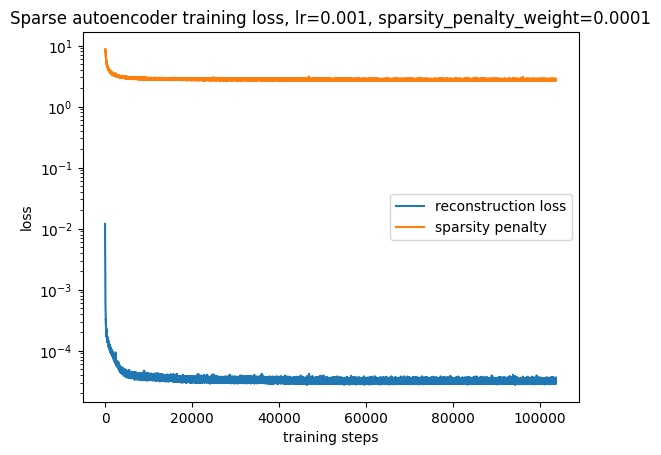

In [13]:
sparse_autoencoder = SparseAutoencoder(model.cfg.dmodel, 4*model.cfg.dmodel).to(device)
training_log = train_sparse_autoencoder( sparse_autoencoder,
                                         train_activations_dataloader,
                                         checkpoint=(0, "mlp"),
                                         epochs=1,
                                         lr=1e-3,
                                         sparsity_penalty_weight=1e-4,
                                         epoch_tqdm=False,
                                         batch_tqdm=True )

In [22]:
test_results = test_sparse_autoencoder( model,
                                        {(0, "mlp"): sparse_autoencoder},
                                        tokens_dataset=val_tokens_dataset,
                                        activations_dataloader=val_activations_dataloader )

  0%|                                                 | 0/11532 [00:00<?, ?it/s]

  0%|                                                | 0/211972 [00:00<?, ?it/s]/home/paperspace/.local/lib/python3.9/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
 24%|████████▋                           | 51435/211972 [09:10<28:57, 92.41it/s]

In [ ]:
test_results

# training the model - don't look at it, we will only train the model from scratch if we have time

In [ ]:
def next_token_logits(model, seq):
    return model(seq)[..., -1, :]

In [ ]:
def repetition_dataset(vocab_size, ncontext, size):
    assert ncontext % 2 == 1
    data = randint(vocab_size, (size, (ncontext + 1) // 2), device=device)
    data = data.repeat(1, 2)
    return TensorDataset(data)

In [ ]:
def transformer_cross_entropy_loss(pred, true):
    return cross_entropy(pred.transpose(1, -1), true.transpose(1, -1))

In [ ]:
def train(model, dataloader, epochs, loss_fn=transformer_cross_entropy_loss, lr=1e-3, epoch_tqdm=True, batch_tqdm=False, plot_loss=True):
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    
    loss_history = []
    for epoch in tqdm(range(epochs)) if epoch_tqdm else range(epochs):
        for x, in tqdm(dataloader) if batch_tqdm else dataloader:
            optimizer.zero_grad()
            loss = loss_fn(model(x[..., :-1]), x[..., 1:])
            loss_history.append(loss.item())
            loss.backward()
            optimizer.step()

    if plot_loss:
        plt.title("training_loss")
        plt.xlabel("training iteration")
        plt.ylabel("loss")
        plt.yscale("log")
        plt.plot(loss_history)
        plt.show()

In [ ]:
cfg = TransformerConfig(vocab_size=10, ncontext=17, dmodel=16, dhead=4, nhead=4, dmlp=32, nlayers=2)
train_dataloader = DataLoader(repetition_dataset(vocab_size=cfg.vocab_size, ncontext=cfg.ncontext, size=500_000), batch_size=64, shuffle=True)
model = Transformer(cfg).to(device)
train(model, train_dataloader, epochs=1, batch_tqdm=True, epoch_tqdm=False)

In [ ]:
test_dataloader = DataLoader(repetition_dataset(vocab_size=cfg.vocab_size, ncontext=cfg.ncontext, size=1_000), batch_size=64, shuffle=True)
x, = next(iter(test_dataloader))
model(x[0, :2])
print(x.shape)
print(model(x[..., :-1]).argmax(-1)[0, ...])
print(x[..., 1:][0, ...])
print(x[..., :-1][0, ...])
print(transformer_cross_entropy_loss(model(x[..., :-1]), x[..., 1:]))